In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/cfrm523/Minute_data')
import pandas as pd

Mounted at /content/drive


In [2]:
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.vector_ar.vecm import coint_johansen
%matplotlib inline
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 4.6 MB/s eta 0:00:00


In [3]:
df = pd.read_csv("crypto_minute_data.csv")

In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
def get_data(df, start, end, ticker):
  data = df.loc[df['ticker'] == ticker]
  data_ = data.loc[data['date'] > start]
  data_ = data_.loc[data_['date'] < end]
  data_ = data_.sort_values(by='date', axis=0)
  data_ = data_.reset_index(drop=True)

  return data_

In [53]:
start = datetime(2024,4,1,0,0,0)
end = datetime(2024,4,1,4,0,0)
ticker = ['BTC-USD', 'ETH-USD', 'LTC-USD', 'BCH-USD', 'XRP-USD']

btc = get_data(df, start, end, ticker[0])
eth = get_data(df, start, end, ticker[1])
ltc = get_data(df, start, end, ticker[2])
bch = get_data(df, start, end, ticker[3])
xrp = get_data(df, start, end, ticker[4])

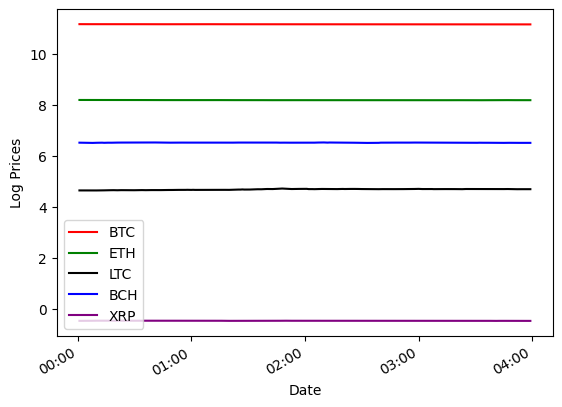

In [54]:
plt.plot(btc['date'], np.log(btc['close']), color = 'r', label='BTC')
plt.plot(eth['date'], np.log(eth['close']), color = 'g', label='ETH')
plt.plot(ltc['date'], np.log(ltc['close']), color = 'black', label='LTC')
plt.plot(bch['date'], np.log(bch['close']), color = 'blue', label='BCH')
plt.plot(xrp['date'], np.log(xrp['close']), color = 'purple', label='XRP')

plt.xlabel("Date")
plt.ylabel("Log Prices")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Adjust the interval as needed
plt.gcf().autofmt_xdate()  # Rotation

plt.legend()  # This will add the legend to the plot
plt.show()

In [55]:
btc['pct_returns'] = btc['close'].pct_change()
eth['pct_returns'] = eth['close'].pct_change()
ltc['pct_returns'] = ltc['close'].pct_change()
bch['pct_returns'] = bch['close'].pct_change()
xrp['pct_returns'] = xrp['close'].pct_change()

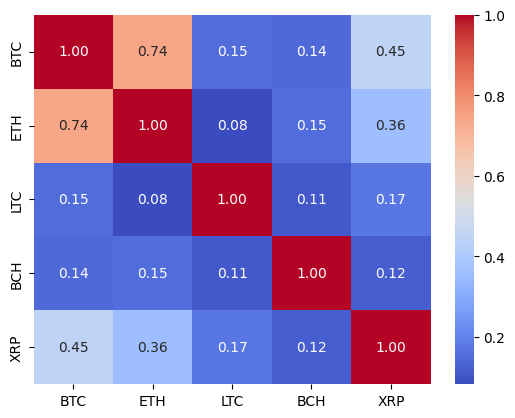

In [56]:
combined_df = pd.concat([btc['pct_returns'], eth['pct_returns'], ltc['pct_returns'], bch['pct_returns'], xrp['pct_returns']], axis=1)
combined_df.columns = ['BTC', 'ETH', 'LTC', 'BCH', 'XRP']

# Calculate the correlation matrix
corr = combined_df.corr()

# Plotting the heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [57]:
df_coint = pd.concat([btc['date'], btc['close'], eth['close'], ltc['close'], bch['close'], xrp['close'] ], axis=1)
df_coint.columns = ['date','BTC', 'ETH', 'LTC', 'BCH', 'XRP']
df_coint.set_index('date', inplace=True)

In [58]:
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.linear_model import LinearRegression
import arch

X = df_coint.drop("BTC", axis=1)
y = df_coint['BTC']
lin_model = LinearRegression()
lin_model.fit(X, y)

LinearRegression()

In [59]:
df_coint_diff = df_coint.diff().dropna()

In [60]:
from arch.unitroot import ADF
from arch.unitroot import KPSS
from arch.unitroot import PhillipsPerron

table_of_stats = {"BTC":[], "ETH":[], "LTC":[], "BCH":[], "XRP":[]}
table_of_stats_diff = {"BTC":[], "ETH":[], "LTC":[], "BCH":[], "XRP":[]}

for i in table_of_stats.keys():
  adf = ADF(df_coint[i])
  pp = PhillipsPerron(df_coint[i])
  kpss = KPSS(df_coint[i])

  table_of_stats[i].append(adf.pvalue)
  table_of_stats[i].append(pp.pvalue)
  table_of_stats[i].append(kpss.pvalue)

for i in table_of_stats_diff.keys():
  adf = ADF(df_coint_diff[i])
  pp = PhillipsPerron(df_coint_diff[i])
  kpss = KPSS(df_coint_diff[i])

  table_of_stats_diff[i].append(adf.pvalue)
  table_of_stats_diff[i].append(pp.pvalue)
  table_of_stats_diff[i].append(kpss.pvalue)

df_table = pd.DataFrame.from_dict(table_of_stats)
df_table_diff = pd.DataFrame.from_dict(table_of_stats_diff)

tests = ["ADF", "PP", "KPSS"]
df_table['Test'] = tests
df_table = df_table.set_index('Test')

df_table_diff['Test'] = tests
df_table_diff = df_table_diff.set_index('Test')

In [61]:
print(df_table)
print(df_table_diff)

           BTC       ETH       LTC       BCH       XRP
Test                                                  
ADF   0.659119  0.189069  0.320037  0.106516  0.629194
PP    0.735785  0.189672  0.323643  0.068249  0.007365
KPSS  0.000100  0.000100  0.000100  0.021584  0.000108
               BTC           ETH           LTC           BCH           XRP
Test                                                                      
ADF   8.086677e-30  2.859327e-27  4.107096e-26  1.157049e-23  1.174995e-11
PP    4.637530e-30  1.634818e-27  4.709075e-26  1.735026e-29  0.000000e+00
KPSS  9.824596e-01  3.088319e-01  1.357316e-01  7.480407e-01  3.695459e-01


In [62]:
coef = np.array([1] + list(-1*lin_model.coef_)) #rolling regression and pull out coefficients (canvas fama french)
print("coefficients: ", coef)
print("intercept: ", lin_model.intercept_)

coefficients:  [ 1.00000000e+00 -9.02176175e+00  1.47993950e+01 -1.14739902e+01
 -3.01655348e+04]
intercept:  13079.940527453655


[]

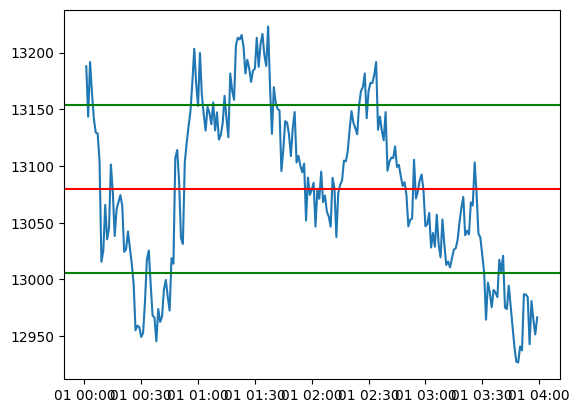

In [63]:
spread = pd.concat([btc['date'], btc['close'], eth['close'], ltc['close'], bch['close'], xrp['close'] ], axis=1)
spread.columns = ['date','BTC', 'ETH', 'LTC', 'BCH', 'XRP']

spread.set_index('date', inplace=True)
#tim_coef = np.array([1,-8.25,73.30,-4.796, -52979.39])
spread['spread'] = spread.dot(coef)

plt.plot(spread.index, spread['spread'])
plt.axhline(y=spread['spread'].mean(), color='r', linestyle='-', label='Horizontal Line at E[spread]')
plt.axhline(y=spread['spread'].mean() + spread['spread'].std(), color='g', linestyle='-', label='UL-Bound')
plt.axhline(y=spread['spread'].mean() - spread['spread'].std(), color='g', linestyle='-')
plt.plot()

In [51]:
spread['spread'].std()

52.58887950139293

In [19]:
spread['spread'].mean()

-17644.353786932017

In [20]:
coef

array([ 1.00000000e+00, -1.08828936e+01,  9.46215832e+01, -1.79113975e+01,
       -7.72969083e+04])

In [22]:
spread.head()

,BTC,ETH,LTC,BCH,XRP,spread
date,,,,,,
2024-04-01 16:01:00,68358.21,3450.51,98.51,637.58,0.599,-17592.947841
2024-04-01 16:02:00,68400.89,3454.48,98.76,640.84,0.600,-17705.505597
2024-04-01 16:03:00,68429.51,3453.88,98.68,637.87,0.600,-17624.728736
2024-04-01 16:04:00,68373.48,3451.16,98.68,639.03,0.600,-17671.934487
2024-04-01 16:05:00,68323.80,3448.72,98.35,636.34,0.600,-17678.103690


In [28]:
-3450.51*10.9 - 0.59*7.72e4 - 17.9*637.58 + 94.6*98.51 + 68358.21

-16893.985